In [1]:
#importing libraries:

import numpy as np
import cv2
from PIL import Image as im
import glob
import os 
from os import listdir
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import argparse
from PIL import Image
import keras
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D


from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np 
import argparse
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential


import matplotlib.pyplot as plt
import random

In [2]:
src_path_train = "../data/frames_train/"
src_path_val = "../data/frames_val/"
src_path_test = "../data/frames_test/"

In [3]:
#Size of our input images
SIZE = 127

In [4]:
batch_size = 10
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    src_path_train,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    color_mode = 'grayscale'
    
    )

validation_generator = datagen.flow_from_directory(
    src_path_val,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    color_mode = 'grayscale'
    
    )

anomaly_generator = datagen.flow_from_directory(
    src_path_test,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    color_mode = 'grayscale'
    
    )



Found 14221 images belonging to 1 classes.
Found 1107 images belonging to 1 classes.
Found 15324 images belonging to 1 classes.


In [5]:

def img_transformation(generators):
    x ,y = generators.__next__()
    x = np.expand_dims(x,axis=4)
    y = x.copy()
    return x ,y
    

In [6]:
x_train, y_train = img_transformation(train_generator)
x_val, y_val = img_transformation(validation_generator)

In [7]:
# x_train, y_train = train_generator.__next__()
# x_train.shape

In [8]:

def load_model(filter, activation, SIZE):
	"""
	Return the model used for abnormal event 
	detection in videos using spatiotemporal autoencoder

	"""
	model=Sequential()
	model.add(Conv3D(filters= filter,kernel_size=(11,11,1),strides=(2,2,1),padding='valid',input_shape=(SIZE,SIZE,1,1),activation=activation))
	model.add(Conv3D(filters= round(filter/2),kernel_size=(5,5,1),strides=(1,1,1),padding='valid',activation=activation))
	model.add(ConvLSTM2D(filters= round(filter/2),kernel_size=(3,3),strides=1,padding='same',dropout=0.1,recurrent_dropout=0.1,return_sequences=True))
	model.add(ConvLSTM2D(filters = round(filter/4),kernel_size=(3,3),strides=1,padding='same',dropout=0.1,return_sequences=True))
	model.add(ConvLSTM2D(filters= round(filter/2),kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.1))
	model.add(Conv3DTranspose(filters= round(filter/2),kernel_size=(5,5,1),strides=(1,1,1),padding='valid',activation=activation))
	model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(2,2,1),padding='valid',activation=activation))

	model.compile(optimizer=Adam(learning_rate = 0.0001),loss='mean_squared_error',metrics=['accuracy'])

	return model

In [9]:
model=load_model(filter = 256, activation = 'LeakyReLU', SIZE = SIZE)
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 59, 59, 1, 256)    31232     
                                                                 
 conv3d_1 (Conv3D)           (None, 55, 55, 1, 128)    819328    
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 55, 55, 1, 128)    1180160   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 55, 55, 1, 64)     442624    
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 55, 55, 1, 128)    885248    
                                                                 
 conv3d_transpose (Conv3DTra  (None, 59, 59, 1, 128)   409728    
 nspose)                                                         
                                                        

In [10]:
callback_save = ModelCheckpoint("AnomalyDetector.h5",
				monitor="mean_squared_error")
#Fit the model. 
history = model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=500,
        validation_data=(x_val, y_val),
        shuffle = True,
        callbacks = [callback_save]
        )

Epoch 1/500
1/1 [==============================] - 9s 9s/step - loss: 0.2235 - accuracy: 6.2000e-06 - val_loss: 0.2256 - val_accuracy: 1.2400e-05
Epoch 2/500
1/1 [==============================] - 1s 953ms/step - loss: 0.2224 - accuracy: 6.2000e-06 - val_loss: 0.2236 - val_accuracy: 1.2400e-05
Epoch 3/500
1/1 [==============================] - 1s 1s/step - loss: 0.2204 - accuracy: 6.2000e-06 - val_loss: 0.2200 - val_accuracy: 1.2400e-05
Epoch 4/500
1/1 [==============================] - 1s 1s/step - loss: 0.2168 - accuracy: 6.2000e-06 - val_loss: 0.2134 - val_accuracy: 1.2400e-05
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 0.2103 - accuracy: 6.2000e-06 - val_loss: 0.2025 - val_accuracy: 1.2400e-05
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 0.1993 - accuracy: 6.2000e-06 - val_loss: 0.1851 - val_accuracy: 1.2400e-05
Epoch 7/500
1/1 [==============================] - 1s 1s/step - loss: 0.1820 - accuracy: 6.2000e-06 - val_loss: 0.1593 - 

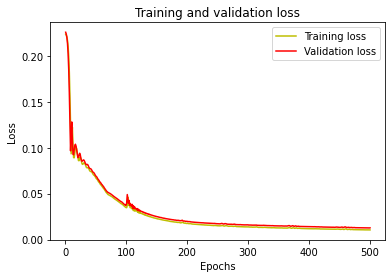

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 347ms/step
(10, 127, 127, 1)


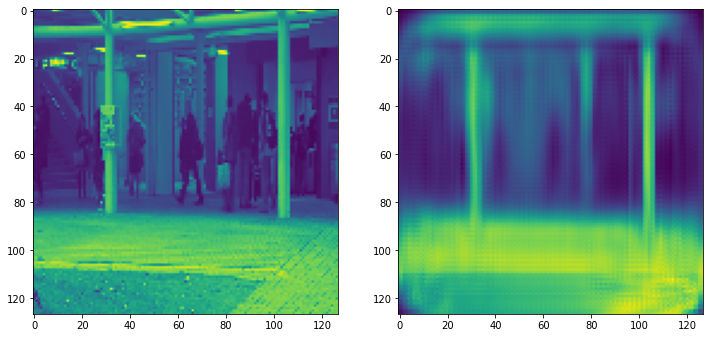

In [14]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0]) #Predict on the first batch of images
predicted = predicted.reshape(batch_size,SIZE,SIZE,1) 
print(predicted.shape)
#print(predicted.reshape(50,227,227,1).shape)

#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [15]:
train_error = model.evaluate(x_train, y_train)
print(train_error)

1/1 [==============================] - 2s 2s/step - loss: 0.0104 - accuracy: 6.2000e-06
[0.01035460364073515, 6.200012194312876e-06]


In [17]:
val_error = model.evaluate(x_val, y_val)
print(val_error)

1/1 [==============================] - 1s 563ms/step - loss: 0.0128 - accuracy: 1.2400e-05
[0.012807968072593212, 1.2400024388625752e-05]
